<a href="https://colab.research.google.com/github/stomioka/phuse-tumor-ml/blob/master/08_tumor_prediction_sites_central_google_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

!pip install git+git://github.com/andirs/impyte.git
!pip install xgboost
!conda install -c anaconda seaborn=0.9.0 -y

# Response criteria prediction for tumor
Sam Tomioka<br>
2019-10-14 
This notebook is for PhUSE AI/ML Project Tumor response prediction challenge using two new datasets provided by Christine Teng.

Previously, in notebook 3-7, following datasets were prepared and trained/tested from the two datasets.

| m | training and validation data |  test data  | test data id |
|---|------------------------------|-------------|--------------|
| 1 | central                      | site        | A            |
| 2 | site                         | central     | B            |
| 3 | central*85%+site*85%         | central*15% | C            |
| 3 | central*85%+site*85%         | site*15%    | D            |

In this notebook, following will be trained/tested since we can consider the central data are used as the primary efficacy endpoint. The idea is that the model trained on the central can be used to identify potential inappropriate assessment of the response criteria, therefore, the accuracy of the model using the site is expected to be lower.


| m | training and validation data |  test data  | test data id |
|---|------------------------------|-------------|--------------|
| 4 | central*70%                  | central*30% | E            |
| 4 | central*70%                  | site        | A            |

The missing imputation will be done using the method used in Notebook 3, 5, 6, and 7. 


# setup for google colab

In [0]:
!pip install xgboost 

!git clone https://github.com/stomioka/phuse-tumor-ml.git
!pip install git+git://github.com/andirs/impyte.git
!mv phuse-tumor-ml phuse_tumor_ml

import os
os.chdir('phuse_tumor_ml/notebooks') #set this as the working directory

Cloning into 'phuse-tumor-ml'...
remote: Enumerating objects: 152, done.
remote: Counting objects: 100% (152/152), done.
remote: Compressing objects: 100% (120/120), done.
remote: Total 152 (delta 79), reused 96 (delta 29), pack-reused 0
Receiving objects: 100% (152/152), 4.90 MiB | 33.22 MiB/s, done.
Resolving deltas: 100% (79/79), done.
  Cloning git://github.com/andirs/impyte.git to /tmp/pip-req-build-wj1qp2g2
  Running command git clone -q git://github.com/andirs/impyte.git /tmp/pip-req-build-wj1qp2g2
  Created wheel for impyte: filename=impyte-0.1.0-cp36-none-any.whl size=21388 sha256=5285f6a8f387a50f236e0a3b6d6de0028e8b5b116a6ad6b913701abd057b37c4
  Stored in directory: /tmp/pip-ephem-wheel-cache-6395hg0f/wheels/65/16/30/1a24d053bf050146af36c12fdca5e3f2362d892226909931e4
Successfully built impyte


In [0]:
 os.getcwd()  #make sure you are in '/content/phuse_tumor_ml/notebooks/phuse_tumor_ml/notebooks'

'/content/phuse_tumor_ml/notebooks/phuse_tumor_ml/notebooks'

## 1 - Import libraries

!conda install -c conda-forge xgboost -y
import xgboost
xgboost.__version__

In [0]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import os
import pickle

from xgboost import XGBClassifier
import scipy, impyte, xgboost, sklearn, matplotlib
from scipy import stats
from impyte import impyte


from sklearn.model_selection import train_test_split\
, cross_val_score, GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, normalize

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score,roc_curve, auc
from sklearn.neighbors import KNeighborsClassifier

from lib import myutil
from lib.myutil import *

from matplotlib import pyplot as plt
from matplotlib import cm as cm
import seaborn as sns
%matplotlib inline

print('sklearn=={}\nxgboost=={}'.format(sklearn.__version__,xgboost.__version__))
print('pandas=={}\nnumpy=={}'.format(pd.__version__,np.__version__))
print('scipy=={}\nimpyte=={}'.format(scipy.__version__,'0.1.0'))
print('seaborn=={}\nmatplotlib=={}'.format(sns.__version__,matplotlib.__version__))

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


sklearn==0.21.3
xgboost==0.90
pandas==0.24.2
numpy==1.16.5
scipy==1.3.1
impyte==0.1.0
seaborn==0.9.0
matplotlib==3.0.3


**Expected versions of libraries**

```sklearn==0.20.3
xgboost==0.90
pandas==0.24.2
numpy==1.17.2
scipy==1.1.0
impyte==0.1.0
seaborn==0.9.0
matplotlib==3.0.3```

## 2. missing data imputation

Notes:
### 2-1. Missing `PCBSD` depends on missing `SUMDIAM`. Missing `SUMDIAM` is assumed MCAR.

```python
central[central['PCBSD'].isnull()]
```

| idx | BSUM | SUMDIAM | PCBSD | NADIR | ACNSD | PCNSD | NEWLSN | TRGRESP | EVAL              |
|-----|------|---------|-------|-------|-------|-------|--------|---------|-------------------|
| 47  | 35   | NaN     | NaN   | 35    | 57    | 0     | 0      | NE      | Central Radiology |
| 95  | 183  | NaN     | NaN   | 183   | -27.6 | 0     | 0      | NE      | Central Radiology |
| 98  | 183  | 64      | NaN   | 70    | -6    | -9    | 1      | NE      | Central Radiology |
| 123 | 85   | 124     | NaN   | 85    | 39    | 46    | 0      | PD      | Central Radiology |
| 126 | 85   | 118     | NaN   | 85    | 33    | 39    | 0      | PD      | Central Radiology |

### 2-2. Imputation of NADIR <This is no longer necessary step>
If `NADIR` is missing, I assume that no post baseline measurement was done, and set it to `NADIR=BSUM`
```python
central[central['NADIR'].isnull()]
```

| idx | BSUM | SUMDIAM | PCBSD | NADIR | ACNSD | PCNSD | NEWLSN | TRGRESP | EVAL              | PCBSD_i |
|-----|------|---------|-------|-------|-------|-------|--------|---------|-------------------|---------|
| 403 | 211  | 211.0   | 0.0   | NaN   | 12.0  | 0     | 0      | NE      | Central Radiology | 0.0     |
| 522 | 61   | 61.0    | 0.0   | NaN   | 0.0   | 0     | 1      | PD      | Central Radiology | 0.0     |
| 546 | 75   | 75.0    | 0.0   | NaN   | 6.0   | 0     | 0      | SD      | Central Radiology | 0.0     |


### 2-3. Imputation of PCBSD

```python
central[central['TRGRESP']=='NE']
```

| idx | BSUM | SUMDIAM | PCBSD | NADIR | ACNSD | PCNSD | NEWLSN | TRGRESP | EVAL              |
|-----|------|---------|-------|-------|-------|-------|--------|---------|-------------------|
| 47  | 35   | NaN     | NaN   | 35    | 57    | 0     | 0      | NE      | Central Radiology |
| 95  | 183  | NaN     | NaN   | 183   | -27.6 | 0     | 0      | NE      | Central Radiology |
| 98  | 183  | 64      | -65   | 70    | -6    | -9    | 1      | NE      | Central Radiology |
| 147 | 81   | NaN     | NaN   | 81    | 6     | 0     | 1      | NE      | Central Radiology |
| 188 | 206  | 179     | -13   | 206   | -27   | -13   | 0      | NE      | Central Radiology |

```python
central[central['PCBSD'].isnull()]
```
| idx | BSUM | SUMDIAM | PCBSD | NADIR | ACNSD | PCNSD | NEWLSN | TRGRESP | EVAL              |
|-----|------|---------|-------|-------|-------|-------|--------|---------|-------------------|
| 47  | 35   | NaN     | NaN   | 35    | 57.0  | 0     | 0      | NE      | Central Radiology |
| 95  | 183  | NaN     | NaN   | 183   | -27.6 | 0     | 0      | NE      | Central Radiology |
| 147 | 81   | NaN     | NaN   | 81    | 6.0   | 0     | 1      | NE      | Central Radiology |
| 195 | 126  | NaN     | NaN   | 126   | -14.0 | 0     | 1      | NE      | Central Radiology |
| 209 | 99   | NaN     | NaN   | 99    | -5.0  | 0     | 0      | NE      | Central Radiology |

When `TRGRESP=='NE'`, `PCBSD` is not necessary missing, but when `PCBSD` is missing, `TRGRESP` is always `NE`. 
It is also true that when `PCBSD` is missing, `SUMDIAM` is missing.

Following imputation steps will be taken for `PCBSD`.
1. Impute PCBSD when SUMDIAM is not missing. (This step is no longer neccessary based on the udpated data)
    - method: `PCBSD=100*(SUMDIAM-BSUM)/BSUM`
2. Impute `SUMDIAM` as `h` (see 2-2-4 for justification) and derive PCBSD using `100*(SUMDIAM-BSUM)/BSUM`.    
    
### 2-4. Imputation of SUMDIAM

```python
central[central['SUMDIAM'].isnull()]
```
| idx | BSUM | SUMDIAM | PCBSD | NADIR | ACNSD | PCNSD | NEWLSN | TRGRESP | EVAL              |
|-----|------|---------|-------|-------|-------|-------|--------|---------|-------------------|
| 47  | 35   | NaN     | NaN   | 35    | 57.0  | 0     | 0      | NE      | Central Radiology |
| 95  | 183  | NaN     | NaN   | 183   | -27.6 | 0     | 0      | NE      | Central Radiology |
| 147 | 81   | NaN     | NaN   | 81    | 6.0   | 0     | 1      | NE      | Central Radiology |
| 195 | 126  | NaN     | NaN   | 126   | -14.0 | 0     | 1      | NE      | Central Radiology |
| 209 | 99   | NaN     | NaN   | 99    | -5.0  | 0     | 0      | NE      | Central Radiology |

When `SUMDIAM` is missing `central[central['SUMDIAM'].isnull()]`, `TRGRESP` is always 'NE'. 
```
SUMDIAM descriptive stat
count    890.000000
mean      62.989888
std       64.852111
min        0.000000
25%       21.000000
50%       46.000000
75%       86.000000
max      640.000000
```
Based on above, I will set `SUMDIAM` to `h` when SUMDIAM is missing, which is an additional hyperparameter during the model optimization to make the models easier to classify the record as `NE`. The goal is not to predict the RECIST criteria when SUMDIAM is missing but classify it as `NE`.

### 2-5. Imputation of NEWLSN
Assume NEWLSN=0 is missing.

### 2-6. Imputation in XGB

- Learn the best imputation using the minimal loss

### 2-7. Other imputation methods
1. Median imputation for continuous variables, set to 0 for NEWLSN
2. K-nearest neighbor
3. Gradient boosting
4. Stochastic gradient descent
5. naive bayes
6. Decision Tree
7. MICE algorithm as described in Van Buuren and Groothuis-Oudshoorn (2011) <-- (use `mice` from `impyte.imputation.cs` or [`mice` package](https://github.com/stefvanbuuren/mice) )
8. no imputation (drop missing)

[1] Azur, Melissa J et al. “Multiple imputation by chained equations: what is it and how does it work?.” International journal of methods in psychiatric research vol. 20,1 (2011): 40-9. doi:10.1002/mpr.329


## 3.  train

### 3-1. random forest

In [0]:
grid_param = {
    'n_estimators': np.arange(1000, 3000, 500)
    , 'criterion': ['gini', 'entropy']
    , 'bootstrap': [True, False]
    , 'max_depth': np.arange(4,10,1)
}


h_lst=[-3000, -1000, 1000, 2000, 3000]

#### rescaling by dividing by a norm of the vector

In [0]:
rf1_best_scores, rf1_best_parms, rf1_best_models, rf1_best_idx= run_models(h_lst=h_lst, m=4,grid_param=grid_param, model='rf')

----Training Method: 4----


#### rescaling by min mix

----Training Method: 4----
----------------------
RandomForestClassifier 0  
              h value: -3000
           Parameters: {'n_estimators': 1500, 'max_depth': 7, 'criterion': 'entropy', 'bootstrap': False}
       Validation Acc: 0.9177018633540373
----------------------
RandomForestClassifier 1  
              h value: -1000
           Parameters: {'n_estimators': 2000, 'max_depth': 7, 'criterion': 'entropy', 'bootstrap': False}
       Validation Acc: 0.9177018633540373
----------------------
RandomForestClassifier 2  
              h value: 1000
           Parameters: {'n_estimators': 1500, 'max_depth': 9, 'criterion': 'gini', 'bootstrap': False}
       Validation Acc: 0.9177018633540373
----------------------
RandomForestClassifier 3  
              h value: 2000
           Parameters: {'n_estimators': 1000, 'max_depth': 9, 'criterion': 'gini', 'bootstrap': False}
       Validation Acc: 0.9192546583850931
----------------------
RandomForestClassifier 4  
              h value: 

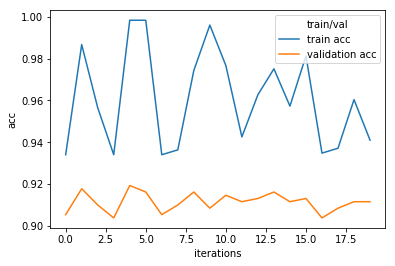

In [0]:
rf2_best_scores, rf2_best_parms, rf2_best_models, rf2_best_idx= run_models(h_lst=h_lst, m=4,grid_param=grid_param, model='rf', scaling_method='minmax')

#### rescaling by removing the median and scales the data according to the IQR

----Training Method: 4----
----------------------
RandomForestClassifier 0  
              h value: -3000
           Parameters: {'n_estimators': 1500, 'max_depth': 7, 'criterion': 'entropy', 'bootstrap': False}
       Validation Acc: 0.9208074534161491
----------------------
RandomForestClassifier 1  
              h value: -1000
           Parameters: {'n_estimators': 1000, 'max_depth': 7, 'criterion': 'entropy', 'bootstrap': False}
       Validation Acc: 0.9177018633540373
----------------------
RandomForestClassifier 2  
              h value: 1000
           Parameters: {'n_estimators': 1000, 'max_depth': 9, 'criterion': 'gini', 'bootstrap': False}
       Validation Acc: 0.9208074534161491
----------------------
RandomForestClassifier 3  
              h value: 2000
           Parameters: {'n_estimators': 2000, 'max_depth': 9, 'criterion': 'gini', 'bootstrap': False}
       Validation Acc: 0.9177018633540373
----------------------
RandomForestClassifier 4  
              h value: 

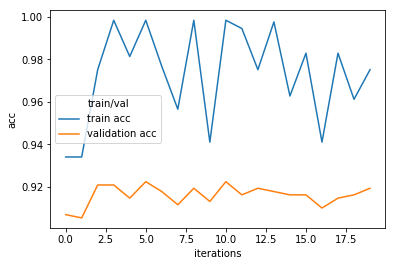

In [0]:
rf3_best_scores, rf3_best_parms, rf3_best_models, rf3_best_idx= run_models(h_lst=h_lst, m=4,grid_param=grid_param, model='rf', scaling_method='maxabs')

#### rescaling by scaling the maximal absolute value of each feature in the training set will be 1.0

----Training Method: 4----
----------------------
RandomForestClassifier 0  
              h value: -3000
           Parameters: {'n_estimators': 2000, 'max_depth': 7, 'criterion': 'entropy', 'bootstrap': False}
       Validation Acc: 0.9192546583850931
----------------------
RandomForestClassifier 1  
              h value: -1000
           Parameters: {'n_estimators': 2500, 'max_depth': 9, 'criterion': 'gini', 'bootstrap': False}
       Validation Acc: 0.9177018633540373
----------------------
RandomForestClassifier 2  
              h value: 1000
           Parameters: {'n_estimators': 1500, 'max_depth': 9, 'criterion': 'gini', 'bootstrap': False}
       Validation Acc: 0.9177018633540373
----------------------
RandomForestClassifier 3  
              h value: 2000
           Parameters: {'n_estimators': 2000, 'max_depth': 9, 'criterion': 'gini', 'bootstrap': False}
       Validation Acc: 0.9177018633540373
----------------------
RandomForestClassifier 4  
              h value: 300

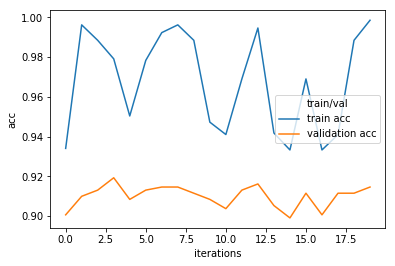

In [0]:
rf4_best_scores, rf4_best_parms, rf4_best_models, rf4_best_idx= run_models(h_lst=h_lst, m=4,grid_param=grid_param, model='rf', scaling_method='robust')

In [0]:
rf_scores=[rf1_best_scores,rf2_best_scores,rf3_best_scores,rf4_best_scores]
best_score=np.array(rf_scores).max()
j=0
for i in rf_scores:

    try:
        idx=i.index(best_score)
        print('\nmodel: {},\nBest model index: {}, \nBest Score: {}'.format(j, idx, best_score))
    except:
        print('\nmodel: {}\nNot best'.format(j))
    j+=1


model: 0
Not best

model: 1
Not best

model: 2,
Best model index: 4, 
Best Score: 0.922360248447205

model: 3
Not best


In [0]:
central,site=load_data()
feature_list=list(central.columns)
importances = list(rf3_best_models[rf3_best_idx].best_estimator_.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
[print('Variable: {:7} Importance: {}'.format(*i)) for i in feature_importances]

Variable: PCBSD   Importance: 0.42
Variable: PCNSD   Importance: 0.19
Variable: SUMDIAM Importance: 0.13
Variable: ACNSD   Importance: 0.12
Variable: NADIR   Importance: 0.08
Variable: BSUM    Importance: 0.05
Variable: NEWLSN  Importance: 0.01


[None, None, None, None, None, None, None]

### 3-2. SVC

----Training Method: 4----
----------------------
SVC 0  
              h value: -3000
           Parameters: {'C': 2.290259045356956, 'gamma': 0.03209172776174814, 'tol': 0.0001}
       Validation Acc: 0.7468944099378882
----------------------
SVC 1  
              h value: -1000
           Parameters: {'C': 2.195955207400232, 'gamma': 0.03900009146119229, 'tol': 0.001}
       Validation Acc: 0.7422360248447205
----------------------
SVC 2  
              h value: 1000
           Parameters: {'C': 1.3683941183619417, 'gamma': 0.024994308678180293, 'tol': 0.001}
       Validation Acc: 0.6847826086956522
----------------------
SVC 3  
              h value: 2000
           Parameters: {'C': 0.9386575350692807, 'gamma': 0.04460183939803958, 'tol': 0.0001}
       Validation Acc: 0.7096273291925466
----------------------
SVC 4  
              h value: 3000
           Parameters: {'C': 1.5913660108153656, 'gamma': 0.021482130305049887, 'tol': 0.001}
       Validation Acc: 0.6847826086956522

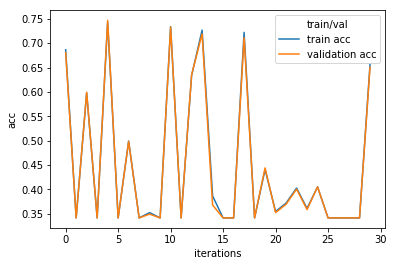

In [0]:
%%time
svc_grid_param = {
    'tol': [1e-3,1e-4]
    , 'C': stats.expon(scale=1)
    , 'gamma':stats.expon(scale=0.01)

}

svc1_best_scores, svc1_best_parms, svc1_best_models, svc1_best_idx= run_models(h_lst=h_lst, m=4,grid_param=svc_grid_param, model='svc')

----Training Method: 4----
----------------------
SVC 0  
              h value: -3000
           Parameters: {'C': 2.140877622905249, 'gamma': 0.027257882289359343, 'tol': 0.001}
       Validation Acc: 0.44565217391304346
----------------------
SVC 1  
              h value: -1000
           Parameters: {'C': 0.615796754975451, 'gamma': 0.02524111555416519, 'tol': 0.0001}
       Validation Acc: 0.422360248447205
----------------------
SVC 2  
              h value: 1000
           Parameters: {'C': 1.0113309508797417, 'gamma': 0.018005907466621153, 'tol': 0.0001}
       Validation Acc: 0.41304347826086957
----------------------
SVC 3  
              h value: 2000
           Parameters: {'C': 1.5687541071938929, 'gamma': 0.009823422616252386, 'tol': 0.0001}
       Validation Acc: 0.4254658385093168
----------------------
SVC 4  
              h value: 3000
           Parameters: {'C': 5.041050747506261, 'gamma': 0.009461464340419758, 'tol': 0.0001}
       Validation Acc: 0.442546583850

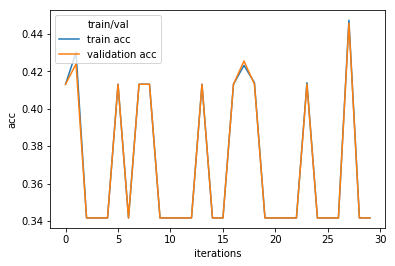

In [0]:
svc2_best_scores, svc2_best_parms, svc2_best_models, svc2_best_idx= run_models(h_lst=h_lst, m=4,grid_param=svc_grid_param, model='svc', scaling_method='minmax')

----Training Method: 4----
----------------------
SVC 0  
              h value: -3000
           Parameters: {'C': 3.645624297744862, 'gamma': 0.016425946747533823, 'tol': 0.001}
       Validation Acc: 0.4673913043478261
----------------------
SVC 1  
              h value: -1000
           Parameters: {'C': 1.7234031579290914, 'gamma': 0.049219702242747534, 'tol': 0.0001}
       Validation Acc: 0.4782608695652174
----------------------
SVC 2  
              h value: 1000
           Parameters: {'C': 5.671397440508577, 'gamma': 0.015584037347733976, 'tol': 0.0001}
       Validation Acc: 0.4813664596273292
----------------------
SVC 3  
              h value: 2000
           Parameters: {'C': 5.10431585613259, 'gamma': 0.013036587213055988, 'tol': 0.001}
       Validation Acc: 0.4704968944099379
----------------------
SVC 4  
              h value: 3000
           Parameters: {'C': 2.134883864300523, 'gamma': 0.023100810269702655, 'tol': 0.0001}
       Validation Acc: 0.464285714285714

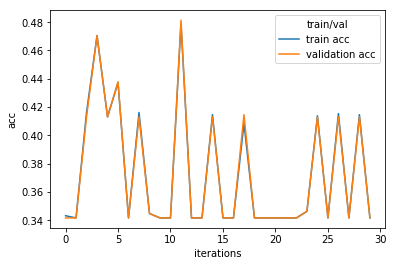

In [0]:
svc3_best_scores, svc3_best_parms, svc3_best_models, svc3_best_idx= run_models(h_lst=h_lst, m=4,grid_param=svc_grid_param, model='svc',  scaling_method='maxabs')

----Training Method: 4----
----------------------
SVC 0  
              h value: -3000
           Parameters: {'C': 7.34444778148409, 'gamma': 0.004783347176721564, 'tol': 0.001}
       Validation Acc: 0.860248447204969
----------------------
SVC 1  
              h value: -1000
           Parameters: {'C': 3.0780694137326665, 'gamma': 0.022450275138727487, 'tol': 0.001}
       Validation Acc: 0.8726708074534162
----------------------
SVC 2  
              h value: 1000
           Parameters: {'C': 1.1626304218809658, 'gamma': 0.029865085988651445, 'tol': 0.001}
       Validation Acc: 0.860248447204969
----------------------
SVC 3  
              h value: 2000
           Parameters: {'C': 1.640779114428286, 'gamma': 0.02043351195426178, 'tol': 0.001}
       Validation Acc: 0.860248447204969
----------------------
SVC 4  
              h value: 3000
           Parameters: {'C': 2.0050327660560647, 'gamma': 0.0350068785778886, 'tol': 0.0001}
       Validation Acc: 0.8695652173913043
----

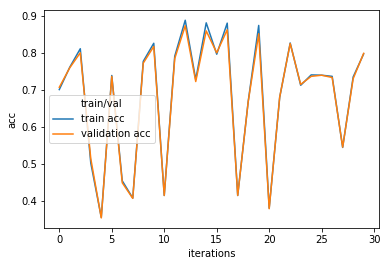

In [0]:
svc4_best_scores, svc4_best_parms, svc4_best_models, svc4_best_idx= run_models(h_lst=h_lst, m=4,grid_param=svc_grid_param, model='svc',  scaling_method='robust')

In [0]:
svc_scores=[svc1_best_scores,svc2_best_scores,svc3_best_scores,svc4_best_scores]
best_score=np.array(svc_scores).max()
j=0
for i in svc_scores:

    try:
        idx=i.index(best_score)
        print('\nmodel: {},\nBest model index: {}, \nBest Score: {}'.format(j, idx, best_score))
    except:
        print('\nmodel: {}\nNot best'.format(j))
    j+=1


model: 0
Not best

model: 1
Not best

model: 2
Not best

model: 3,
Best model index: 1, 
Best Score: 0.8726708074534162


### 3-3 . Logistic Regression

----Training Method: 4----
----------------------
LogisticRegression 0  
              h value: -3000
           Parameters: {'C': 3.2471400121205876, 'max_iter': 1000, 'solver': 'newton-cg', 'tol': 0.0001}
       Validation Acc: 0.8059006211180124
----------------------
LogisticRegression 1  
              h value: -1000
           Parameters: {'C': 3.51352287264093, 'max_iter': 1000, 'solver': 'lbfgs', 'tol': 0.0001}
       Validation Acc: 0.8043478260869565
----------------------
LogisticRegression 2  
              h value: 1000
           Parameters: {'C': 3.5269422098880514, 'max_iter': 2000, 'solver': 'lbfgs', 'tol': 0.0001}
       Validation Acc: 0.8136645962732919
----------------------
LogisticRegression 3  
              h value: 2000
           Parameters: {'C': 4.083875113572522, 'max_iter': 1000, 'solver': 'saga', 'tol': 0.0001}
       Validation Acc: 0.8229813664596274
----------------------
LogisticRegression 4  
              h value: 3000
           Parameters: {'C': 

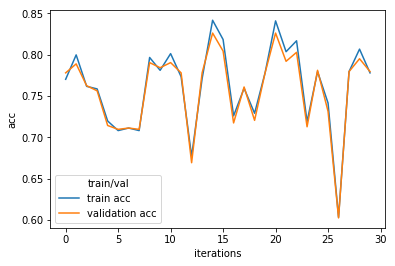

In [0]:
%%time
lr_grid_param = {
    'tol': [1e-3,1e-4]
    , 'C': stats.expon(scale=1)
    , 'solver': ['lbfgs','saga','newton-cg']
    , 'max_iter':[1000, 2000]
}

lr1_best_scores, lr1_best_parms, lr1_best_models, lr1_best_idx= run_models(h_lst=h_lst, m=4,grid_param=lr_grid_param, model='lr')

----Training Method: 4----
----------------------
LogisticRegression 0  
              h value: -3000
           Parameters: {'C': 6.474159059503519, 'max_iter': 1000, 'solver': 'lbfgs', 'tol': 0.001}
       Validation Acc: 0.7717391304347826
----------------------
LogisticRegression 1  
              h value: -1000
           Parameters: {'C': 3.634995214780267, 'max_iter': 1000, 'solver': 'newton-cg', 'tol': 0.001}
       Validation Acc: 0.7267080745341615
----------------------
LogisticRegression 2  
              h value: 1000
           Parameters: {'C': 3.0081589126771346, 'max_iter': 1000, 'solver': 'saga', 'tol': 0.001}
       Validation Acc: 0.7049689440993789
----------------------
LogisticRegression 3  
              h value: 2000
           Parameters: {'C': 4.963734685542149, 'max_iter': 2000, 'solver': 'lbfgs', 'tol': 0.001}
       Validation Acc: 0.7437888198757764
----------------------
LogisticRegression 4  
              h value: 3000
           Parameters: {'C': 4.59

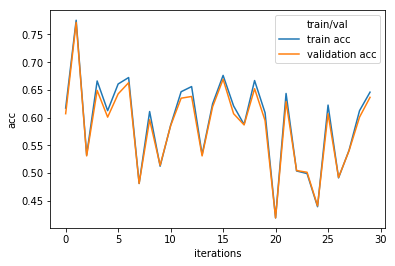

In [0]:
lr2_best_scores, lr2_best_parms, lr2_best_models, lr2_best_idx= run_models(h_lst=h_lst, m=4,grid_param=lr_grid_param, model='lr', scaling_method='minmax')

----Training Method: 4----
----------------------
LogisticRegression 0  
              h value: -3000
           Parameters: {'C': 5.1954606007008985, 'max_iter': 1000, 'solver': 'saga', 'tol': 0.0001}
       Validation Acc: 0.7795031055900621
----------------------
LogisticRegression 1  
              h value: -1000
           Parameters: {'C': 4.5446526805676415, 'max_iter': 1000, 'solver': 'lbfgs', 'tol': 0.0001}
       Validation Acc: 0.7732919254658385
----------------------
LogisticRegression 2  
              h value: 1000
           Parameters: {'C': 3.5702902439991226, 'max_iter': 1000, 'solver': 'lbfgs', 'tol': 0.001}
       Validation Acc: 0.7531055900621118
----------------------
LogisticRegression 3  
              h value: 2000
           Parameters: {'C': 3.5509227870751747, 'max_iter': 1000, 'solver': 'newton-cg', 'tol': 0.001}
       Validation Acc: 0.7453416149068323
----------------------
LogisticRegression 4  
              h value: 3000
           Parameters: {'C':

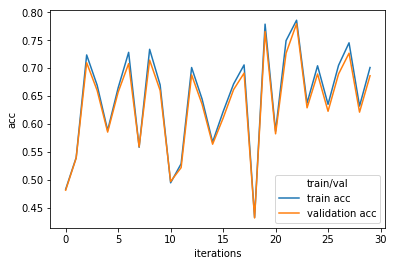

In [0]:
lr3_best_scores, lr3_best_parms, lr3_best_models, lr3_best_idx= run_models(h_lst=h_lst, m=4,grid_param=lr_grid_param, model='lr', scaling_method='maxabs')

----Training Method: 4----
----------------------
LogisticRegression 0  
              h value: -3000
           Parameters: {'C': 0.9893193266056811, 'max_iter': 2000, 'solver': 'lbfgs', 'tol': 0.001}
       Validation Acc: 0.8913043478260869
----------------------
LogisticRegression 1  
              h value: -1000
           Parameters: {'C': 0.9320900010256818, 'max_iter': 2000, 'solver': 'lbfgs', 'tol': 0.0001}
       Validation Acc: 0.8913043478260869
----------------------
LogisticRegression 2  
              h value: 1000
           Parameters: {'C': 1.9730872029909763, 'max_iter': 1000, 'solver': 'newton-cg', 'tol': 0.0001}
       Validation Acc: 0.889751552795031
----------------------
LogisticRegression 3  
              h value: 2000
           Parameters: {'C': 1.417478416217828, 'max_iter': 1000, 'solver': 'newton-cg', 'tol': 0.0001}
       Validation Acc: 0.8881987577639752
----------------------
LogisticRegression 4  
              h value: 3000
           Parameters: {

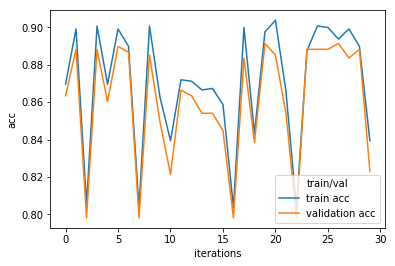

In [0]:
lr4_best_scores, lr4_best_parms, lr4_best_models, lr4_best_idx= run_models(h_lst=h_lst, m=4,grid_param=lr_grid_param, model='lr', scaling_method='robust')

In [0]:
lr_scores=[lr1_best_scores,lr2_best_scores,lr3_best_scores,lr4_best_scores]
best_score=np.array(lr_scores).max()
j=0
for i in lr_scores:

    try:
        idx=i.index(best_score)
        print('\nmodel: {},\nBest model index: {}, \nBest Score: {}'.format(j, idx, best_score))
    except:
        print('\nmodel: {}\nNot best'.format(j))
    j+=1


model: 0
Not best

model: 1
Not best

model: 2
Not best

model: 3,
Best model index: 0, 
Best Score: 0.8913043478260869


### 3-4. knn

----Training Method: 4----
----------------------
KNeighborsClassifier 0  
              h value: -3000
           Parameters: {'leaf_size': 20, 'p': 1, 'weights': 'distance'}
       Validation Acc: 0.8509316770186336
----------------------
KNeighborsClassifier 1  
              h value: -1000
           Parameters: {'leaf_size': 20, 'p': 1, 'weights': 'distance'}
       Validation Acc: 0.8509316770186336
----------------------
KNeighborsClassifier 2  
              h value: 1000
           Parameters: {'leaf_size': 20, 'p': 1, 'weights': 'distance'}
       Validation Acc: 0.8493788819875776
----------------------
KNeighborsClassifier 3  
              h value: 2000
           Parameters: {'leaf_size': 20, 'p': 1, 'weights': 'distance'}
       Validation Acc: 0.8509316770186336
----------------------
KNeighborsClassifier 4  
              h value: 3000
           Parameters: {'leaf_size': 20, 'p': 1, 'weights': 'distance'}
       Validation Acc: 0.8509316770186336
---------------------

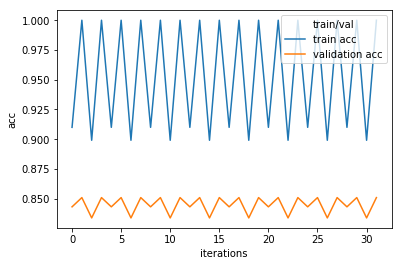

In [0]:
%%time
knn_grid_param = {
            'weights': ['uniform','distance']
            , 'p': [1,2]
            , 'leaf_size': np.arange(20,60,5)
}

knn1_best_scores, knn1_best_parms, knn1_best_models, knn1_best_idx= run_models(h_lst=h_lst, m=4,grid_param=knn_grid_param, model='knn')

----Training Method: 4----
----------------------
KNeighborsClassifier 0  
              h value: -3000
           Parameters: {'leaf_size': 20, 'p': 2, 'weights': 'distance'}
       Validation Acc: 0.843167701863354
----------------------
KNeighborsClassifier 1  
              h value: -1000
           Parameters: {'leaf_size': 20, 'p': 2, 'weights': 'distance'}
       Validation Acc: 0.84472049689441
----------------------
KNeighborsClassifier 2  
              h value: 1000
           Parameters: {'leaf_size': 20, 'p': 2, 'weights': 'distance'}
       Validation Acc: 0.8416149068322981
----------------------
KNeighborsClassifier 3  
              h value: 2000
           Parameters: {'leaf_size': 20, 'p': 2, 'weights': 'distance'}
       Validation Acc: 0.84472049689441
----------------------
KNeighborsClassifier 4  
              h value: 3000
           Parameters: {'leaf_size': 20, 'p': 2, 'weights': 'distance'}
       Validation Acc: 0.843167701863354
----------------------
Best

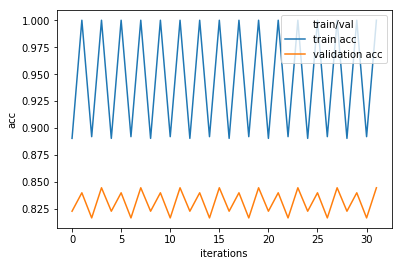

In [0]:
knn2_best_scores, knn2_best_parms, knn2_best_models, knn2_best_idx= run_models(h_lst=h_lst, m=4,grid_param=knn_grid_param, model='knn', scaling_method='minmax')

----Training Method: 4----
----------------------
KNeighborsClassifier 0  
              h value: -3000
           Parameters: {'leaf_size': 20, 'p': 1, 'weights': 'distance'}
       Validation Acc: 0.8416149068322981
----------------------
KNeighborsClassifier 1  
              h value: -1000
           Parameters: {'leaf_size': 20, 'p': 1, 'weights': 'distance'}
       Validation Acc: 0.84472049689441
----------------------
KNeighborsClassifier 2  
              h value: 1000
           Parameters: {'leaf_size': 20, 'p': 1, 'weights': 'distance'}
       Validation Acc: 0.84472049689441
----------------------
KNeighborsClassifier 3  
              h value: 2000
           Parameters: {'leaf_size': 20, 'p': 1, 'weights': 'distance'}
       Validation Acc: 0.843167701863354
----------------------
KNeighborsClassifier 4  
              h value: 3000
           Parameters: {'leaf_size': 20, 'p': 1, 'weights': 'distance'}
       Validation Acc: 0.8416149068322981
----------------------
Bes

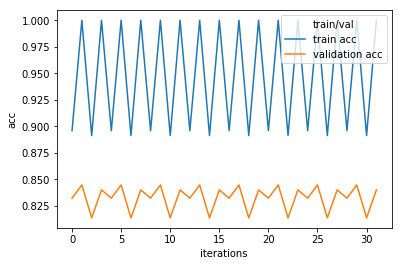

In [0]:
knn3_best_scores, knn3_best_parms, knn3_best_models, knn3_best_idx= run_models(h_lst=h_lst, m=4,grid_param=knn_grid_param, model='knn', scaling_method='maxabs')

----Training Method: 4----
----------------------
KNeighborsClassifier 0  
              h value: -3000
           Parameters: {'leaf_size': 20, 'p': 2, 'weights': 'distance'}
       Validation Acc: 0.8555900621118012
----------------------
KNeighborsClassifier 1  
              h value: -1000
           Parameters: {'leaf_size': 20, 'p': 2, 'weights': 'distance'}
       Validation Acc: 0.8555900621118012
----------------------
KNeighborsClassifier 2  
              h value: 1000
           Parameters: {'leaf_size': 20, 'p': 2, 'weights': 'distance'}
       Validation Acc: 0.8524844720496895
----------------------
KNeighborsClassifier 3  
              h value: 2000
           Parameters: {'leaf_size': 20, 'p': 2, 'weights': 'distance'}
       Validation Acc: 0.8524844720496895
----------------------
KNeighborsClassifier 4  
              h value: 3000
           Parameters: {'leaf_size': 20, 'p': 2, 'weights': 'distance'}
       Validation Acc: 0.8524844720496895
---------------------

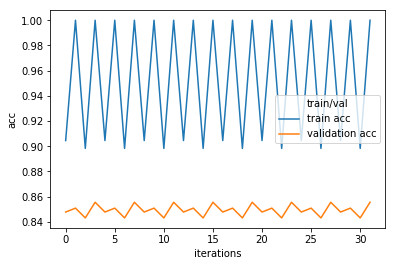

In [0]:
knn4_best_scores, knn4_best_parms, knn4_best_models, knn4_best_idx= run_models(h_lst=h_lst, m=4,grid_param=knn_grid_param, model='knn', scaling_method='robust')

In [0]:
knn_scores=[knn1_best_scores,knn2_best_scores,knn3_best_scores,knn4_best_scores]
best_score=np.array(knn_scores).max()
j=0
for i in knn_scores:

    try:
        idx=i.index(best_score)
        print('\nmodel: {},\nBest model index: {}, \nBest Score: {}'.format(j, idx, best_score))
    except:
        print('\nmodel: {}\nNot best'.format(j))
    j+=1


model: 0
Not best

model: 1
Not best

model: 2
Not best

model: 3,
Best model index: 0, 
Best Score: 0.8555900621118012


### 3-5. XGB

----Training Method: 4----
Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   25.2s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   48.8s finished


----------------------
XGBClassifier 0  
              h value: -3000
           Parameters: {'min_child_weight': 3, 'max_depth': 13, 'gamma': 0.0, 'colsample_bytree': 0.8}
       Validation Acc: 0.9021739130434783
Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   25.1s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   48.6s finished


----------------------
XGBClassifier 1  
              h value: -1000
           Parameters: {'min_child_weight': 3, 'max_depth': 13, 'gamma': 0.0, 'colsample_bytree': 0.8}
       Validation Acc: 0.9021739130434783
Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   25.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   48.5s finished


----------------------
XGBClassifier 2  
              h value: 1000
           Parameters: {'min_child_weight': 1, 'max_depth': 13, 'gamma': 0.5, 'colsample_bytree': 0.8}
       Validation Acc: 0.8990683229813664
Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   25.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   48.3s finished


----------------------
XGBClassifier 3  
              h value: 2000
           Parameters: {'min_child_weight': 1, 'max_depth': 13, 'gamma': 0.5, 'colsample_bytree': 0.8}
       Validation Acc: 0.8990683229813664
Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   24.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   48.3s finished


----------------------
XGBClassifier 4  
              h value: 3000
           Parameters: {'min_child_weight': 1, 'max_depth': 13, 'gamma': 0.5, 'colsample_bytree': 0.8}
       Validation Acc: 0.9006211180124224
----------------------
Best XGBClassifier Model: 0
        Parameters: {'min_child_weight': 3, 'max_depth': 13, 'gamma': 0.0, 'colsample_bytree': 0.8} 
                 h: -3000 
    Validation Acc: 0.9021739130434783
CPU times: user 3min 57s, sys: 493 ms, total: 3min 58s
Wall time: 4min 17s


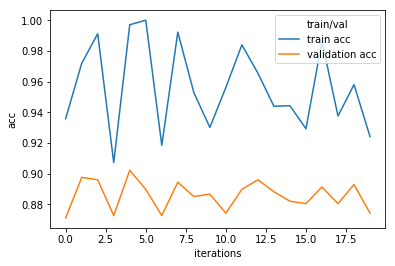

In [0]:
%%time
xgb_grid_param = {
        'colsample_bytree': np.arange(0.1,1.5,0.1)
        ,'min_child_weight': np.arange(1,8,2)
        ,'gamma': np.arange(0,3,.5)
        ,'colsample_bytree': [0.4, 0.8, 0.1]
        ,'max_depth': np.arange(8,14,1)
        #,'learning_rate': [0.01,0.1]
        #,'n_estimators': [1000, 800]

        }

xgb1_best_scores, xgb1_best_parms, xgb1_best_models, xgb1_best_idx= run_models(h_lst=h_lst, m=4,grid_param=xgb_grid_param, model='xgb')

----Training Method: 4----
Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   21.8s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   42.4s finished


----------------------
XGBClassifier 0  
              h value: -3000
           Parameters: {'min_child_weight': 1, 'max_depth': 13, 'gamma': 0.0, 'colsample_bytree': 0.4}
       Validation Acc: 0.9347826086956522
Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   21.9s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   42.4s finished


----------------------
XGBClassifier 1  
              h value: -1000
           Parameters: {'min_child_weight': 1, 'max_depth': 13, 'gamma': 0.0, 'colsample_bytree': 0.4}
       Validation Acc: 0.9347826086956522
Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   21.8s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   41.9s finished


----------------------
XGBClassifier 2  
              h value: 1000
           Parameters: {'min_child_weight': 1, 'max_depth': 13, 'gamma': 0.5, 'colsample_bytree': 0.8}
       Validation Acc: 0.9332298136645962
Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   21.8s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   42.0s finished


----------------------
XGBClassifier 3  
              h value: 2000
           Parameters: {'min_child_weight': 1, 'max_depth': 13, 'gamma': 0.5, 'colsample_bytree': 0.8}
       Validation Acc: 0.9332298136645962
Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   21.9s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   42.4s finished


----------------------
XGBClassifier 4  
              h value: 3000
           Parameters: {'min_child_weight': 1, 'max_depth': 13, 'gamma': 0.5, 'colsample_bytree': 0.8}
       Validation Acc: 0.9332298136645962
----------------------
Best XGBClassifier Model: 0
        Parameters: {'min_child_weight': 1, 'max_depth': 13, 'gamma': 0.0, 'colsample_bytree': 0.4} 
                 h: -3000 
    Validation Acc: 0.9347826086956522


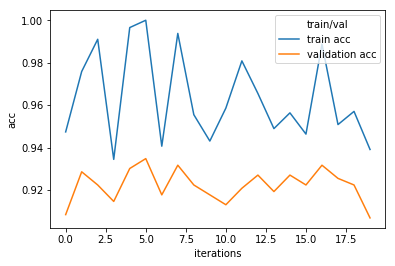

In [0]:
xgb2_best_scores, xgb2_best_parms, xgb2_best_models, xgb2_best_idx= run_models(h_lst=h_lst, m=4,grid_param=xgb_grid_param, model='xgb', scaling_method='minmax')

----Training Method: 4----
Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   21.9s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   42.4s finished


----------------------
XGBClassifier 0  
              h value: -3000
           Parameters: {'min_child_weight': 1, 'max_depth': 13, 'gamma': 0.0, 'colsample_bytree': 0.4}
       Validation Acc: 0.9347826086956522
Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   21.9s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   42.3s finished


----------------------
XGBClassifier 1  
              h value: -1000
           Parameters: {'min_child_weight': 1, 'max_depth': 13, 'gamma': 0.0, 'colsample_bytree': 0.4}
       Validation Acc: 0.9347826086956522
Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   21.8s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   42.0s finished


----------------------
XGBClassifier 2  
              h value: 1000
           Parameters: {'min_child_weight': 1, 'max_depth': 13, 'gamma': 0.5, 'colsample_bytree': 0.8}
       Validation Acc: 0.9332298136645962
Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   21.8s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   42.1s finished


----------------------
XGBClassifier 3  
              h value: 2000
           Parameters: {'min_child_weight': 1, 'max_depth': 13, 'gamma': 0.5, 'colsample_bytree': 0.8}
       Validation Acc: 0.9332298136645962
Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   21.9s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   42.0s finished


----------------------
XGBClassifier 4  
              h value: 3000
           Parameters: {'min_child_weight': 1, 'max_depth': 13, 'gamma': 0.5, 'colsample_bytree': 0.8}
       Validation Acc: 0.9332298136645962
----------------------
Best XGBClassifier Model: 0
        Parameters: {'min_child_weight': 1, 'max_depth': 13, 'gamma': 0.0, 'colsample_bytree': 0.4} 
                 h: -3000 
    Validation Acc: 0.9347826086956522


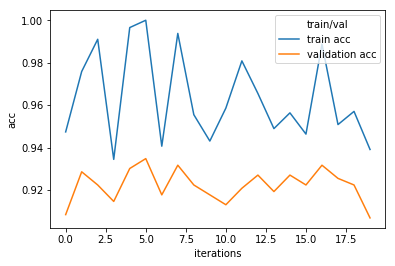

In [0]:
xgb3_best_scores, xgb3_best_parms, xgb3_best_models, xgb3_best_idx= run_models(h_lst=h_lst, m=4,grid_param=xgb_grid_param, model='xgb', scaling_method='maxabs')

----Training Method: 4----
Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   22.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   42.4s finished


----------------------
XGBClassifier 0  
              h value: -3000
           Parameters: {'min_child_weight': 1, 'max_depth': 13, 'gamma': 0.0, 'colsample_bytree': 0.4}
       Validation Acc: 0.9347826086956522
Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   22.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   42.3s finished


----------------------
XGBClassifier 1  
              h value: -1000
           Parameters: {'min_child_weight': 1, 'max_depth': 13, 'gamma': 0.0, 'colsample_bytree': 0.4}
       Validation Acc: 0.9347826086956522
Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   21.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   42.3s finished


----------------------
XGBClassifier 2  
              h value: 1000
           Parameters: {'min_child_weight': 1, 'max_depth': 13, 'gamma': 0.5, 'colsample_bytree': 0.8}
       Validation Acc: 0.9332298136645962
Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   21.8s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   42.0s finished


----------------------
XGBClassifier 3  
              h value: 2000
           Parameters: {'min_child_weight': 1, 'max_depth': 13, 'gamma': 0.5, 'colsample_bytree': 0.8}
       Validation Acc: 0.9332298136645962
Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   21.8s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   41.9s finished


----------------------
XGBClassifier 4  
              h value: 3000
           Parameters: {'min_child_weight': 1, 'max_depth': 13, 'gamma': 0.5, 'colsample_bytree': 0.8}
       Validation Acc: 0.9332298136645962
----------------------
Best XGBClassifier Model: 0
        Parameters: {'min_child_weight': 1, 'max_depth': 13, 'gamma': 0.0, 'colsample_bytree': 0.4} 
                 h: -3000 
    Validation Acc: 0.9347826086956522


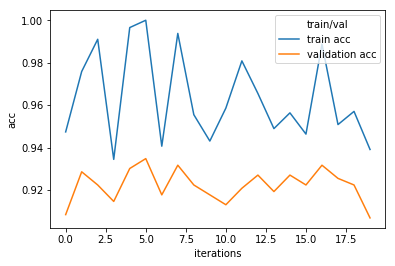

In [0]:
xgb4_best_scores, xgb4_best_parms, xgb4_best_models, xgb4_best_idx= run_models(h_lst=h_lst, m=4,grid_param=xgb_grid_param, model='xgb', scaling_method='robust')

In [0]:
xgb_scores=[xgb1_best_scores,xgb2_best_scores,xgb3_best_scores,xgb4_best_scores]
best_score=np.array(xgb_scores).max()
j=0
for i in xgb_scores:

    try:
        idx=i.index(best_score)
        print('\nmodel: {},\nBest model index: {}, \nBest Score: {}'.format(j, idx, best_score))
    except:
        print('\nmodel: {}\nNot best'.format(j))
    j+=1


model: 0
Not best

model: 1,
Best model index: 0, 
Best Score: 0.9347826086956522

model: 2,
Best model index: 0, 
Best Score: 0.9347826086956522

model: 3,
Best model index: 0, 
Best Score: 0.9347826086956522


## 4. evaluate cv results

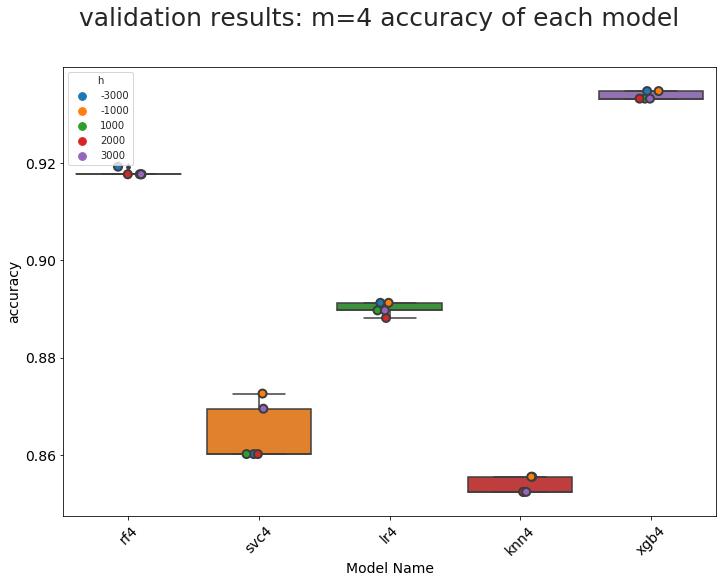

In [0]:
df=pd.DataFrame(
    {'rf4': rf4_best_scores,
     'svc4': svc4_best_scores,
     'lr4': lr4_best_scores,
     'knn4': knn4_best_scores,
     'xgb4': xgb4_best_scores,
     'h':h_lst
    })

df=df.melt(id_vars='h', var_name='model name', value_name='accuracy')
plot_model_performance(df, 'validation results: m=4', hue='h')

In [0]:
df

,h,model name,accuracy
0,-3000,rf4,0.919255
1,-1000,rf4,0.917702
2,1000,rf4,0.917702
3,2000,rf4,0.917702
4,3000,rf4,0.917702
5,-3000,svc4,0.860248
6,-1000,svc4,0.872671
7,1000,svc4,0.860248
8,2000,svc4,0.860248
9,3000,svc4,0.869565


- save models

In [0]:
best_models=[rf4_best_models, svc4_best_models, lr4_best_models, knn4_best_models, xgb4_best_models]
save_models(df, mo=best_models)

## 5 test-accuracy using best model from each ML algorithm

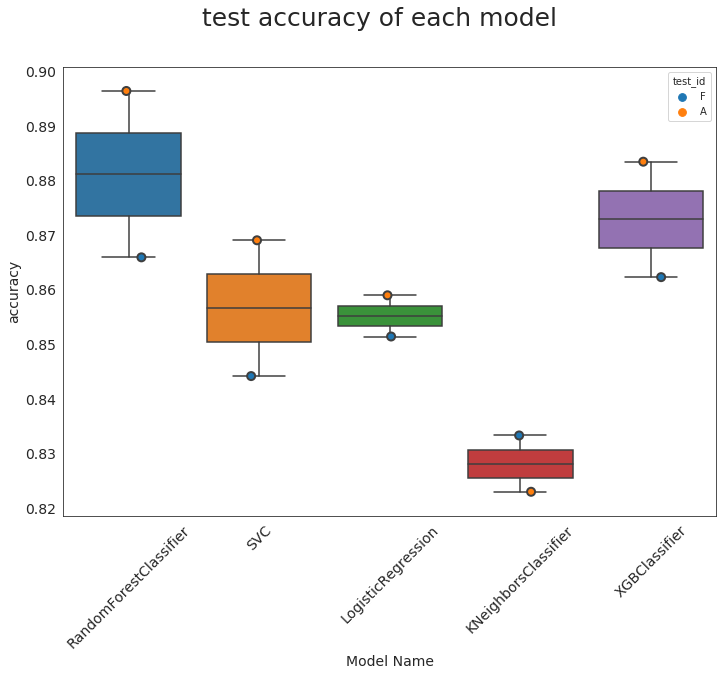

[0.8659420289855072,
 0.8964028776978418,
 0.8442028985507246,
 0.8690647482014389,
 0.8514492753623188,
 0.8589928057553957,
 0.8333333333333334,
 0.823021582733813,
 0.8623188405797102,
 0.883453237410072]

In [0]:
best_models=[rf4_best_models, svc4_best_models, lr4_best_models, knn4_best_models, xgb4_best_models]
best_idx=[rf4_best_idx, svc4_best_idx, lr4_best_idx, knn4_best_idx, xgb4_best_idx]

test_accuracy(best_idx, best_models,'test', h_lst, m=4, scaling_method='robust' )

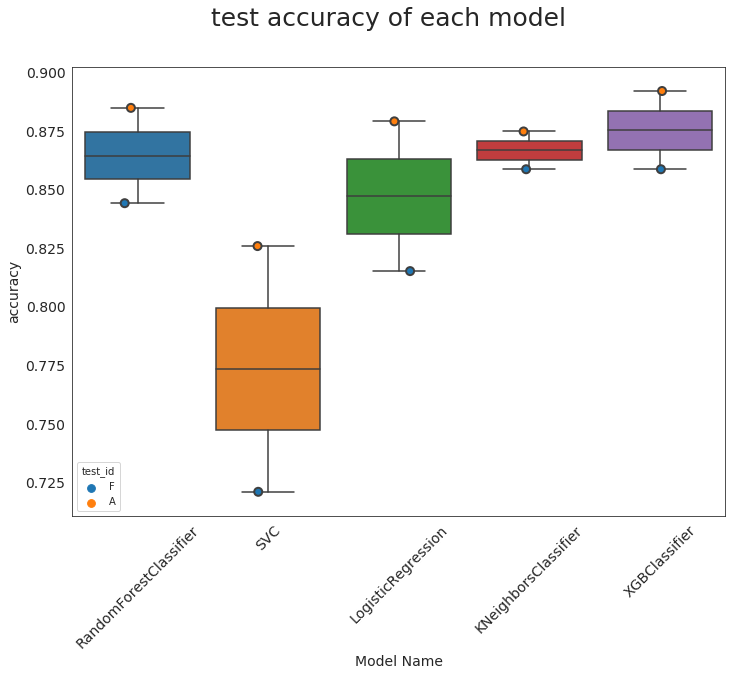

[0.8442028985507246,
 0.8848920863309353,
 0.7210144927536232,
 0.8258992805755395,
 0.8152173913043478,
 0.879136690647482,
 0.8586956521739131,
 0.874820143884892,
 0.8586956521739131,
 0.8920863309352518]

In [0]:
best_models=[rf1_best_models, svc1_best_models, lr1_best_models, knn1_best_models, xgb1_best_models]
best_idx=[rf1_best_idx, svc1_best_idx, lr1_best_idx, knn1_best_idx, xgb1_best_idx]

test_accuracy(best_idx, best_models,'test', h_lst, m=4 )

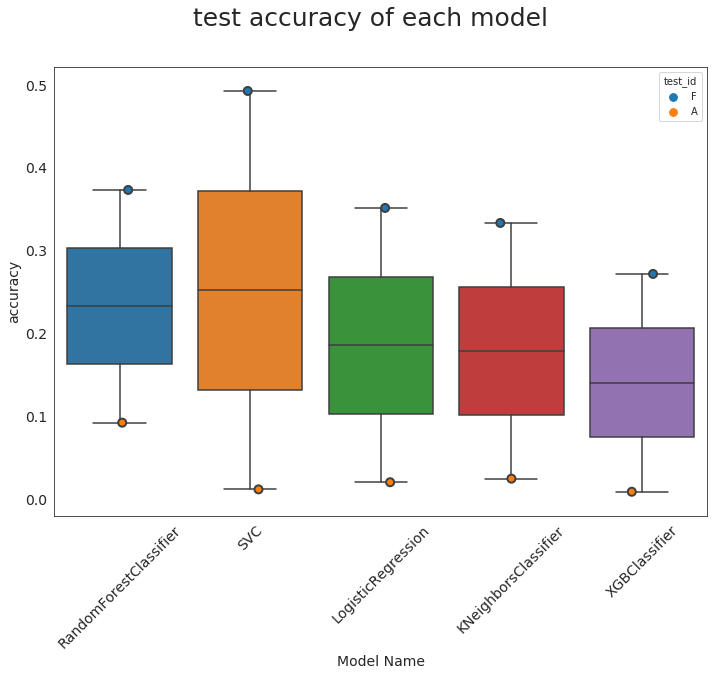

[0.37318840579710144,
 0.0920863309352518,
 0.4927536231884058,
 0.011510791366906475,
 0.35144927536231885,
 0.02014388489208633,
 0.3333333333333333,
 0.02446043165467626,
 0.2717391304347826,
 0.008633093525179856]

In [0]:
best_models=[rf2_best_models, svc2_best_models, lr2_best_models, knn2_best_models, xgb2_best_models]
best_idx=[rf2_best_idx, svc2_best_idx, lr2_best_idx, knn2_best_idx, xgb2_best_idx]

test_accuracy(best_idx, best_models,'test', h_lst, m=4,  scaling_method='minmax')

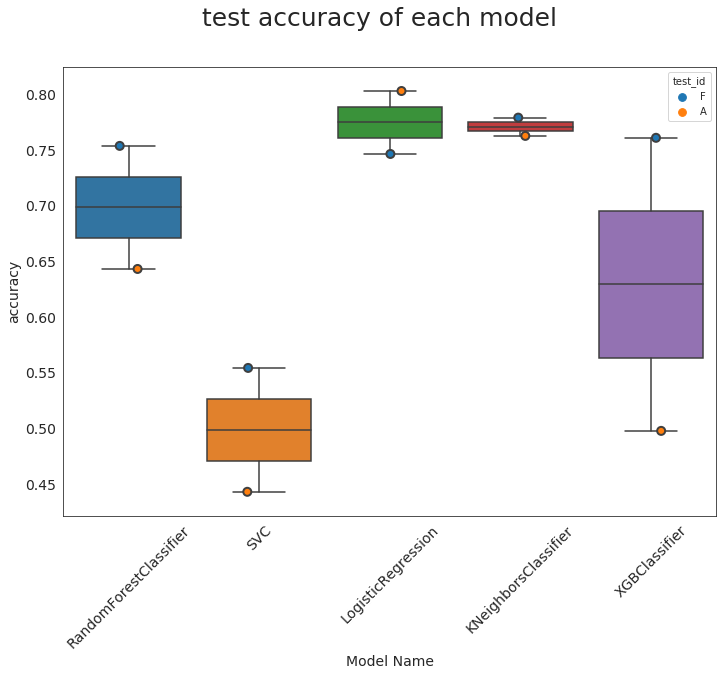

[0.7536231884057971,
 0.6431654676258993,
 0.5543478260869565,
 0.44316546762589926,
 0.7463768115942029,
 0.8028776978417266,
 0.7789855072463768,
 0.762589928057554,
 0.7608695652173914,
 0.497841726618705]

In [0]:
best_models=[rf3_best_models, svc3_best_models, lr3_best_models, knn3_best_models, xgb3_best_models]
best_idx=[rf3_best_idx, svc3_best_idx, lr3_best_idx, knn3_best_idx, xgb3_best_idx]

test_accuracy(best_idx, best_models,'test', h_lst, m=4,  scaling_method='maxabs')

## Summary



Five algorithms were tested to predict RECIST responses including not evaluable. All these algorithms consistently outperformed on test data consist of only site assessments as compared with central data when the models were trained using the data from central assessments . The accuracy rate was below 90% for central assessment.

Various imputation values were used for SUMDIAM to train the models and confirmed that the imputation values do affect the performance of the models. 

Other parametric and non-parametric imputation methods will be evaluated for the training data to see whether these affect the performance of the models.